# Building the Configuration of the Final Model

In this notebook, it is covered the conformation of the final regression model to predict cars prices. To this aim, the next steps will be followed:
* Divide the dataset into train & split values.
* Train a Random Forest Regressor with the optimal hyperparameters found.
* Predict on test data.
* Plot actual vs predicted values.
* Model persistence. Saving the model with pickle.

In [1]:
import pandas as pd
import numpy as np
from time import time
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from modules.model_evaluator import run_cv_reg, eval_reg
from modules.plotter import plot_model_eval

## 1. Import data

In [2]:
root = r'../data/regression/cars_reg_trf.csv'

df = pd.read_csv(root)

df.head()

,year,kms,seats,power,co2_emiss,height,length,width,trunk_vol,max_speed,...,doors_2,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded
0,-0.644829,-0.283562,-2.013252,-1.683986,-1.120443,0.285121,-2.877530,-2.759382,-1.498581,-2.143610,...,5.199338,-5.199338,-5.199338,-5.199338,-1.579469,-1.083566,-1.505232,-0.902609,5.199338,0.608153
1,-1.079060,-5.199338,-1.168798,1.199172,1.303557,-1.624785,-0.685567,-0.070384,-1.022354,1.345832,...,-5.199338,5.199338,-5.199338,-5.199338,0.329890,-0.367258,0.314018,-0.902609,5.199338,1.837526
2,5.199338,-5.199338,0.130979,0.494090,-0.572277,-1.297705,0.171631,-0.298225,-0.169083,0.937119,...,-5.199338,-5.199338,5.199338,-5.199338,0.829514,0.818931,0.596109,5.199338,5.199338,1.837526
3,0.060316,0.266857,0.130979,1.065669,0.635580,0.540027,0.519795,0.997262,0.429809,0.651025,...,-5.199338,-5.199338,-5.199338,5.199338,0.829514,1.653661,-1.056848,-0.902609,5.199338,1.837526
4,-1.513075,0.383683,-2.013252,2.675154,3.742522,-2.967122,0.012559,1.257931,-0.757254,-0.174181,...,5.199338,-5.199338,-5.199338,-5.199338,-1.183849,0.277283,-0.287738,-0.319300,5.199338,1.837526


## 2. Dividing the dataset

In [3]:
X = df.drop('price', axis=1)
y = df['price']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(44260, 35) (11066, 35) (44260,) (11066,)


## 3. Train RF with the optimal hyperparameters

The hyperparameters for the `RF` have been chosen based on the results of the Grid Search cross-validation process:
- `bootstrap`: False
- `max_depth`: 100
- `max_features`: 'sqrt'
- `min_samples_leaf`: 2
- `min_samples_split`: 2
- `n_estimators`: 250

In [5]:
start_time = time()

rf = RandomForestRegressor(bootstrap=False,
                           max_features='sqrt',
                           min_samples_split=2,
                           min_samples_leaf=2,
                           n_estimators=250,
                           max_depth=100
                          )

rf.fit(X_train, y_train)

exec_time = time() - start_time
print('The RF model was trained in: {:.2f} sec'.format(exec_time))

The RF model was trained in: 23.70 sec


## 4. Predict on test data: Evaluation of the model

In [6]:
y_hat = rf.predict(X_test)

display(y_hat)
print("Min value predicted: {:.2f}\n\
Max value predicted: {:.2f}"\
      .format(np.min(y_hat), np.max(y_hat)))
print("y_hat shape: {}".format(y_hat.shape))

array([15235.3081254 , 12293.03485429,  7386.98331413, ...,
       25583.8883968 , 14348.50806951, 10366.626779  ])

Min value predicted: 1015.75
Max value predicted: 92969.26
y_hat shape: (11066,)


Time to evaluate the prediction of the model. It needs to be generalized using cross-validation to verify if the model is stable and feasible to be used on new inputs.

![Under- and overfitting](https://djsaunde.files.wordpress.com/2017/07/bias-variance-tradeoff.png)

In [7]:
models = []
models.append(('RF', rf))

df_models, results = run_cv_reg(X, y, models, 'r2')

Executing RF...
CV finished for RF


In [8]:
df_models

,model,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec
0,RF,0.9328,0.9382,0.9423,0.9417,0.0048,0.9435,0.9501,251.4017


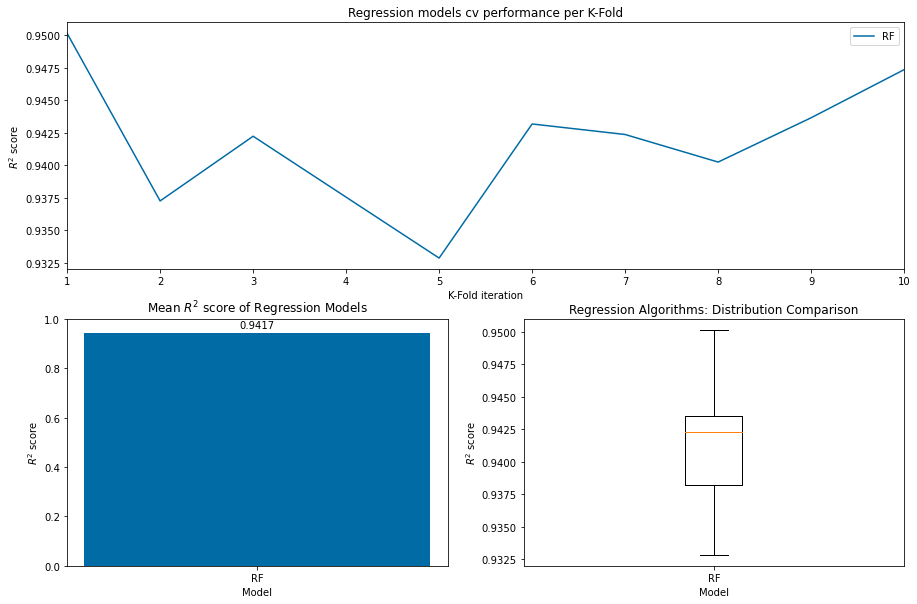

In [9]:
plot_model_eval(df_models, results)

In [10]:
eval_reg(y_test, y_hat)

### MEASURES OF REGRESSION MODEL ###
------------------------------------

R2 = 0.9396

RMSE = 3165.7334

MSE = 10021868.1484

MSLE = 0.0390

MAE = 1760.0435

EVS = 93.9592%



## 5. Actual vs Predicted values: Residual Plots

First, let's have a look at the predicted values that the model produced related to each feature:

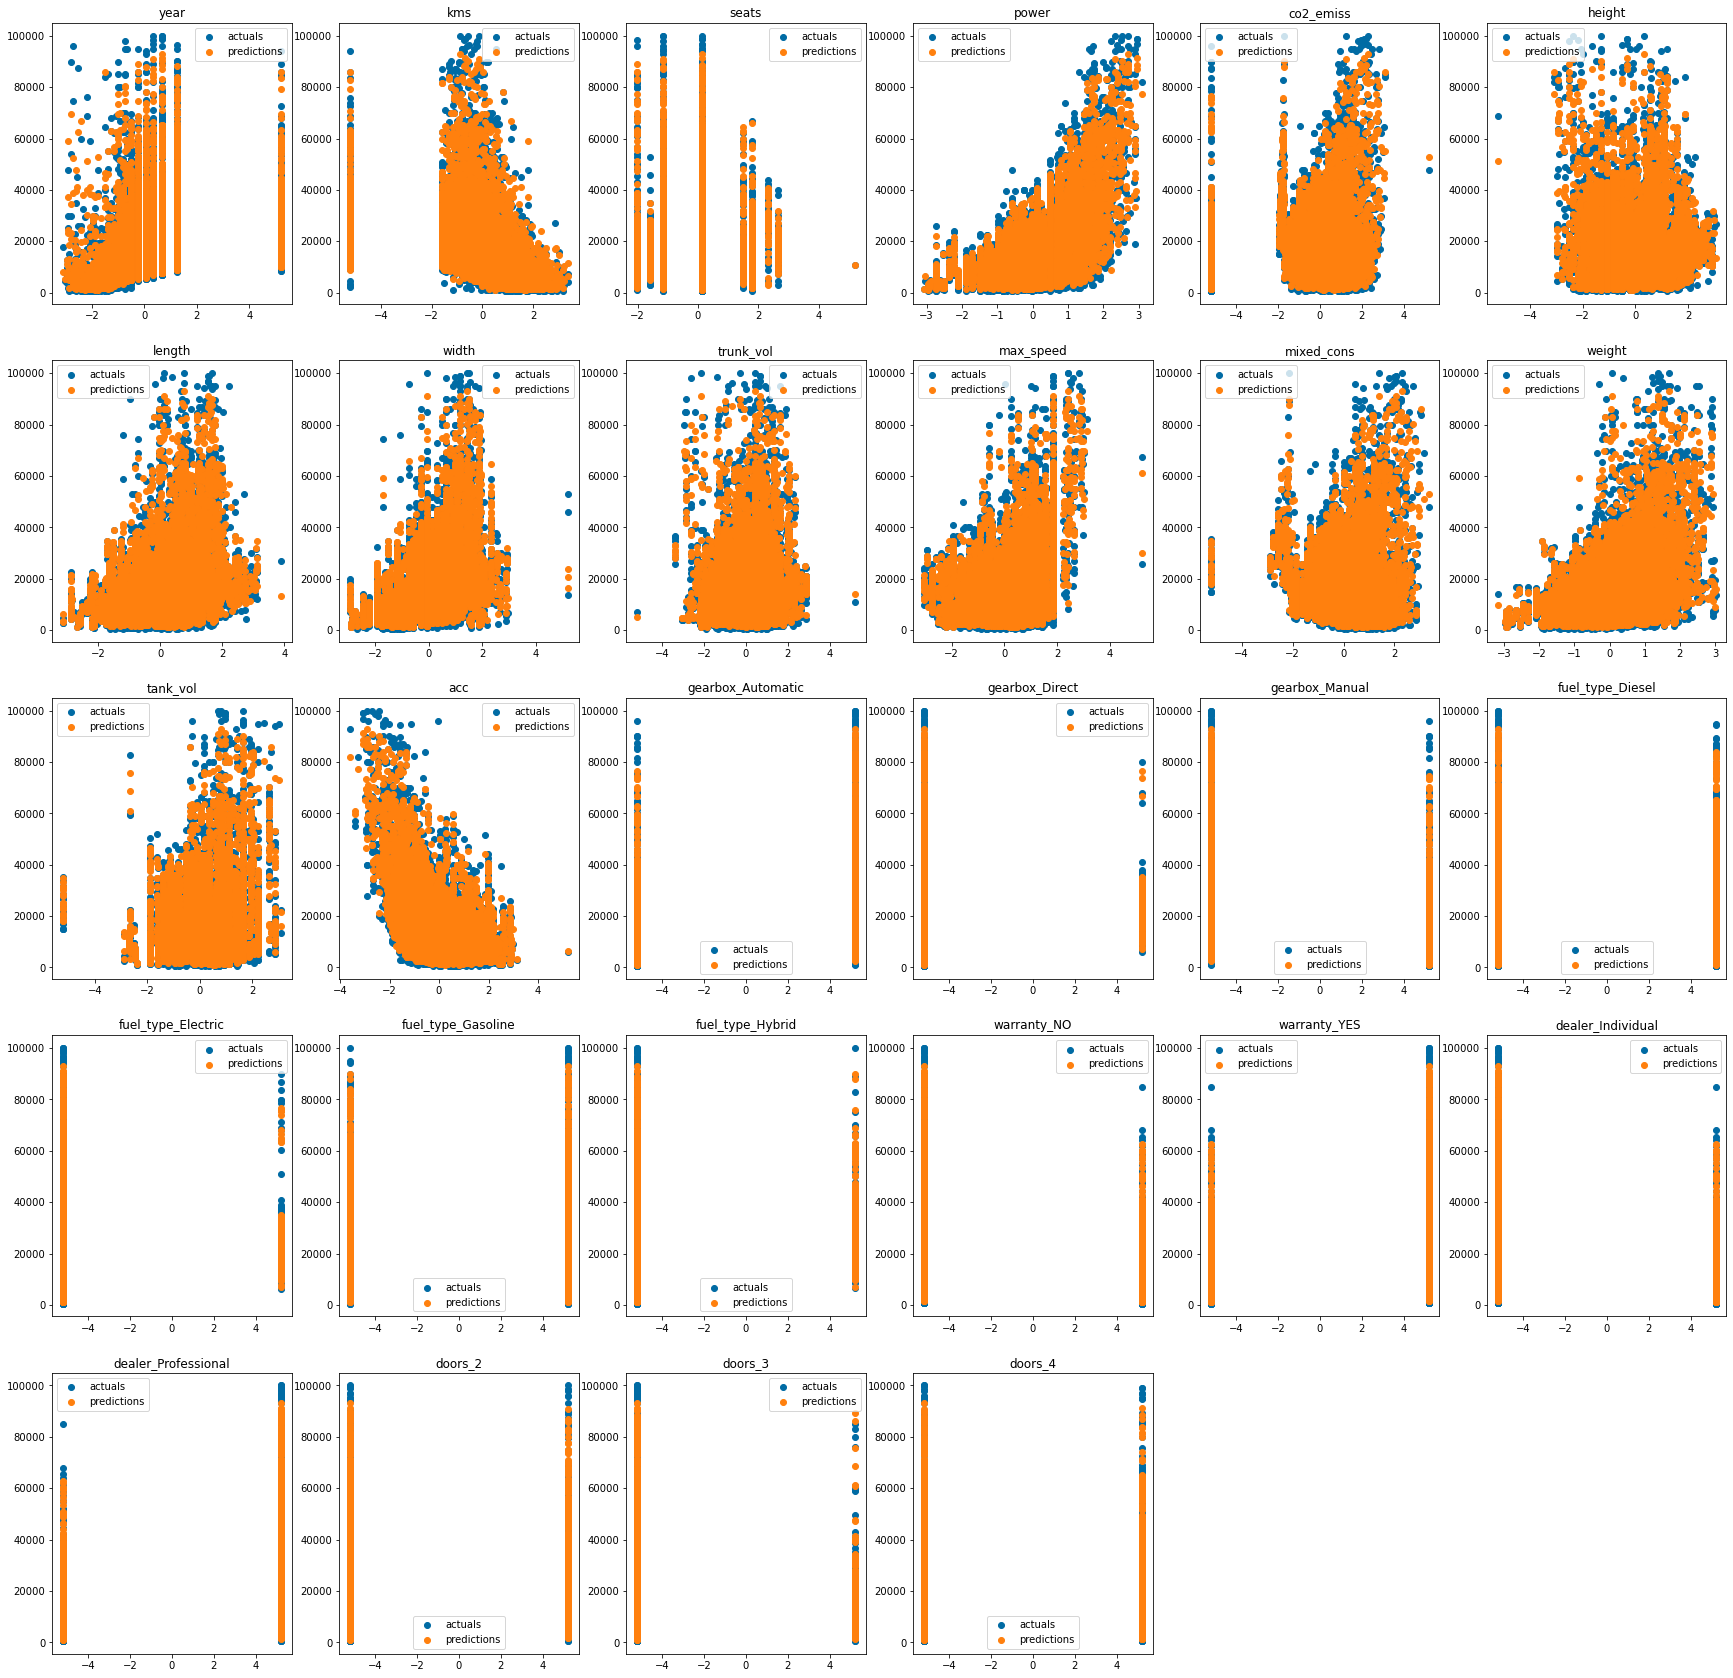

In [11]:
fig = plt.figure(figsize=(30,30))

columns = X_test.columns

for c, num in zip(columns, range(0,28)):
    ax = fig.add_subplot(5, 6, num+1)
    ax.scatter(X_test[c], y_test)
    ax.scatter(X_test[c], y_hat)
    ax.set_title(c)
    ax.legend(['actuals', 'predictions'])
    
plt.savefig('fig/12_columns_pred.png')
plt.show()

It is visible that the values are correctly predicted, especially for cheaper cars. This is due to the fact that the dataset have less samples of luxury second-hand cars. Now, we will have a look at the predictions of the whole model to see how they are adapted to actual values.

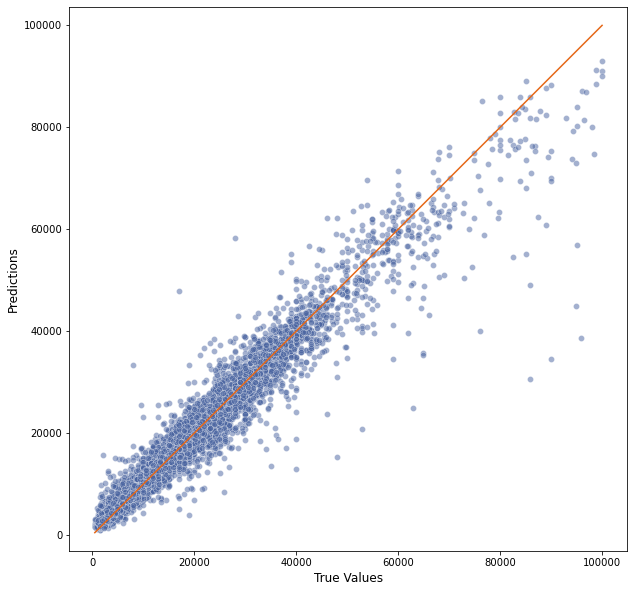

In [12]:
plt.style.use("tableau-colorblind10")
plt.figure(figsize=(10,10))

sns.scatterplot(x=y_test, y=y_hat, color='#4863A0', alpha=0.5)

p1 = max(max(y_hat), max(y_test))
p2 = min(min(y_hat), min(y_test))
sns.lineplot(x=[p1, p2], y=[p1, p2], color='#E56717')

plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.axis('equal')

plt.savefig('fig/12_model_pred.png')
plt.show()

From the above scatter plot of Actual vs Predicted values, it is possible to take the following conclusions:
- The closer the scatter points are to the regression line, the better the model. The $R²\ score$ obtained was of **0.8905**, which is a relativelly high score. This results in all the points being close to the diagonal line. The lower the $R²\ score$, the weaker the goodnes of fit of the model.
- Having a deeper look into the values, we can conclude that the higher the price of the car, the more dispersed is the model. This affirmation was already visible when analysing the prediction of each feature. The number of second-hand cars with a value higher than **60,000 €** are scarce compared to more accesible cars. Therefore, we could expect a better performance of the model when predicting prices of non-luxury cars.
- Residual values are those separated from the regression line. If they are above the line, they are positive, whereas if they are below, they are negative. Residuals seem to be balanced for lower prices, nevertheless negative values seem to be predominant with higher prices. Thereupon, there can be underestimations on predicting cars with a higher market value.

In any case, the performance of our model will be more than acceptable since the points are fit to the regression line and the $R²\ score$ value is close to **0.94**.

## 6. Model persistence

<img align="center" src="https://programaenlinea.net/wp-content/uploads/2017/09/python-pickle-800x200.png">

In [13]:
from modules.pickle_jar import create_pickle, compressed_pickle, decompress_pickle
from pathlib import Path
import os

Defining the model to be saved. The fit will be based on the entire dataset to enrich the model, no separations into train & test sets. This process is based on the explanation of compressed pickles commented in [this article](https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e).

In [14]:
rf_model = RandomForestRegressor(bootstrap=False,
                                 max_features='sqrt',
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 n_estimators=250,
                                 max_depth=100
                                )

rf_model.fit(X, y)

RandomForestRegressor(bootstrap=False, max_depth=100, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=250)

Time to save this model using pickle!

In [15]:
create_pickle("models/rf_model.pkl", rf_model)

In [16]:
Path("models/rf_model.pkl").stat().st_size

601923355

In [17]:
compressed_pickle("models/rf_model", rf_model)

In [18]:
Path("models/rf_model.pbz2").stat().st_size

124882684

In [19]:
size_rel = Path("models/rf_model.pkl").stat().st_size / Path("models/rf_model.pbz2").stat().st_size
print("Pickle wo/ being compressed is {:.2f}% heavier in size.".format(size_rel * 100))

Pickle wo/ being compressed is 481.99% heavier in size.


Since the size of the compressed file is much lighter in size, we will use this one and delete the normal pickle version.

In [20]:
os.remove("models/rf_model.pkl")

Let's see if we can decompress and load the created pickle:

In [21]:
pickle_model = decompress_pickle("models/rf_model.pbz2")

In [22]:
score = pickle_model.score(X_test, y_test)
print("Test score: {:.2f}%".format(score * 100))
y_predict = pickle_model.predict(X_test)

Test score: 98.78%


### We finally saved our model in a pickle!
Now it is possible to reuse this model and apply it to new data. Time to explore its performance.

<img width=500 src="https://i.pinimg.com/originals/93/c2/64/93c264fed54a077870340f043d6b3667.jpg">